In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc

from sklearn.utils import resample

import warnings
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('semua_terpakai.csv', encoding = 'utf-16')
df['POS']= np.where(df['senti'] == 'positif', '1', '0')
df['NET']= np.where(df['senti'] == 'netral', '1', '0')
df['NEG']= np.where(df['senti'] == 'negatif', '1', '0')
df['TER']= np.where(df['level_bahasa'] == 'teratur', '1', '0')
df['SED']= np.where(df['level_bahasa'] == 'sedang', '1', '0')
df['TTE']= np.where(df['level_bahasa'] == 'tidak teratur', '1', '0')
df['IND']= np.where(df['jenis_bahasa'] == 'Indonesia_murni', '1', '0')
df['CBI']= np.where(df['jenis_bahasa'] == 'campur_bahasa_Inggris', '1', '0')
df['CBD']= np.where(df['jenis_bahasa'] == 'campur_bahasa_daerah', '1', '0')
df['ENG']= np.where(df['jenis_bahasa'] == 'Inggris_murni', '1', '0')

#y = df.balance
#X = df.drop('balance', axis=1)
df_majority = df[df.CBI== '0' ]

df_minority = df[df.CBI== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1027,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.CBD== '0' ]

df_minority_2 = df_upsampled[df_upsampled.CBD== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=1027,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])


df_majority_3 = df_upsampled_2[df_upsampled_2.ENG== '0' ]

df_minority_3 = df_upsampled_2[df_upsampled_2.ENG== '1']

df_minority_upsampled_3 = resample(df_minority_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=1027,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_3 = pd.concat([df_majority_3, df_minority_upsampled_3])
df_upsampled_3.jenis_bahasa.value_counts()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Indonesia_murni          1027
campur_bahasa_daerah     1027
Inggris_murni            1027
campur_bahasa_Inggris    1027
Name: jenis_bahasa, dtype: int64

In [2]:
df_upsampled_3.Comment=df_upsampled_3.Comment.astype(str)
df_upsampled_3

,Comment,sentiment,senti,jenis_bahasa,level_bahasa,POS,NET,NEG,TER,SED,TTE,IND,CBI,CBD,ENG
2,terserah lah mau ngomong apa pusing denger dia ngomong,-0.1,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0
3,mirip protokol di parkiran motor helm hilang resiko di tanggung sendiri,-0.6,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
5,semoga selalu dlm lindungan allah subhanahu wataala aamiin,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
6,menang d pengadilan dunia tapi tunggu pengadilan akhirat,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,what,-0.01,negatif,Inggris_murni,teratur,0,0,1,1,0,0,0,0,0,1
924,new world order,0,netral,Inggris_murni,teratur,0,1,0,1,0,0,0,0,0,1
1120,prank,-0.01,negatif,Inggris_murni,teratur,0,0,1,1,0,0,0,0,0,1
31,new presiden,0,netral,Inggris_murni,teratur,0,1,0,1,0,0,0,0,0,1


In [3]:
df_=df_upsampled_3.drop(['sentiment','senti','jenis_bahasa','level_bahasa','POS','NET','NEG','TER','SED','TTE'], axis =1)
df_

,Comment,IND,CBI,CBD,ENG
2,terserah lah mau ngomong apa pusing denger dia ngomong,1,0,0,0
3,mirip protokol di parkiran motor helm hilang resiko di tanggung sendiri,1,0,0,0
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,1,0,0,0
5,semoga selalu dlm lindungan allah subhanahu wataala aamiin,1,0,0,0
6,menang d pengadilan dunia tapi tunggu pengadilan akhirat,1,0,0,0
...,...,...,...,...,...
1265,what,0,0,0,1
924,new world order,0,0,0,1
1120,prank,0,0,0,1
31,new presiden,0,0,0,1


In [4]:
df_['IND']=df_['IND'].astype(int)
df_['CBI']=df_['CBI'].astype(int)
df_['CBD']=df_['CBD'].astype(int)
df_['ENG']=df_['ENG'].astype(int)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_, test_size=0.2, random_state = 23)
train

,Comment,IND,CBI,CBD,ENG
132,ntah,1,0,0,0
888,tatanan dunia baru yang lebih pokok e terserah kalian,0,0,1,0
452,new normal bahasa halus herd imunity seleksi alam positif nya ekonomi akan normal kembali negatifnya kalo imun yg lemah akan kalah,0,1,0,0
936,mantap ini benar presiden org rakyatnya sulit diatur,1,0,0,0
1159,mbingungi dewe mutusi dewe nglarang dewe sakarep dewe,0,0,1,0
...,...,...,...,...,...
235,mari kita sukseskan program pemerintah demi terciptanya lapangan kerja baru bagi warga china di indonesia sehingga indonesia akan dapat diskon vaksin covid made in china,0,1,0,0
289,kumaha ilaing we lah den,0,0,1,0
780,kan udah berdamai knpa takut king of prank in the world,0,1,0,0
702,mall di buka tempat ibadah ga di buka new normal banget,0,1,0,0


In [6]:
list_classes = ['IND','CBI','CBD','ENG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comment"]
list_sentences_test = test["Comment"]

In [7]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[:1]

[[2274]]

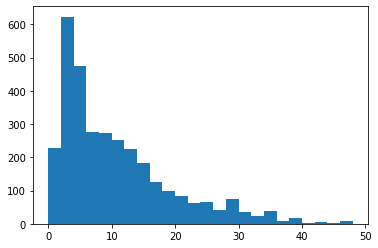

In [8]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,50,2))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [9]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [10]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [11]:


#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("model300.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [12]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

3170 845
known words: 3170
unknown words: 845


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [13]:
print(emb_init_values)

[[ 1.9398055   0.9223579   1.1527607  ... -0.35870504 -3.8962324
  -0.5033255 ]
 [ 1.4031776   0.5934335   0.40442282 ... -0.35535118  0.5263745
  -0.6059853 ]
 [-0.11076635 -0.05123871 -0.36495847 ... -0.7535308  -0.3139119
  -1.0396185 ]
 ...
 [-0.02307803 -0.01487702  0.06136963 ...  0.18777505 -0.16337214
   0.13654903]
 [-0.04786429 -0.06130136  0.05477637 ...  0.04583774 -0.04700583
   0.01991991]
 [-0.03173166 -0.04810882 -0.17340027 ... -0.15480968  0.1700234
   0.13565932]]


In [14]:
emb_init_values.shape

(4016, 300)

In [15]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [16]:
inp = Input(shape=(maxlen,))

In [17]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4108 entries, 2 to 1120
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  4108 non-null   object
 1   IND      4108 non-null   int32 
 2   CBI      4108 non-null   int32 
 3   CBD      4108 non-null   int32 
 4   ENG      4108 non-null   int32 
dtypes: int32(4), object(1)
memory usage: 128.4+ KB


In [18]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(4, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

Epoch 1/100

 ROC-AUC - epoch: 1 - score: 0.969059 

103/103 - 11s - loss: 0.3495 - accuracy: 0.6741 - val_loss: 0.1825 - val_accuracy: 0.8674
Epoch 2/100

 ROC-AUC - epoch: 2 - score: 0.994635 

103/103 - 10s - loss: 0.1245 - accuracy: 0.9117 - val_loss: 0.0729 - val_accuracy: 0.9501
Epoch 3/100

 ROC-AUC - epoch: 3 - score: 0.995727 

103/103 - 10s - loss: 0.0506 - accuracy: 0.9705 - val_loss: 0.0578 - val_accuracy: 0.9720
Epoch 4/100

 ROC-AUC - epoch: 4 - score: 0.997061 

103/103 - 11s - loss: 0.0261 - accuracy: 0.9875 - val_loss: 0.0366 - val_accuracy: 0.9830
Epoch 5/100

 ROC-AUC - epoch: 5 - score: 0.997139 

103/103 - 11s - loss: 0.0149 - accuracy: 0.9927 - val_loss: 0.0336 - val_accuracy: 0.9854
Epoch 6/100

 ROC-AUC - epoch: 6 - score: 0.996296 

103/103 - 10s - loss: 0.0179 - accuracy: 0.9912 - val_loss: 0.0533 - val_accuracy: 0.9781
Epoch 7/100

 ROC-AUC - epoch: 7 - score: 0.996523 

103/103 - 10s - loss: 0.0314 - accuracy: 0.9817 - val_loss: 0.0536 - val_accuracy: 0.9745

Epoch 57/100

 ROC-AUC - epoch: 57 - score: 0.996880 

103/103 - 10s - loss: 0.0163 - accuracy: 0.9930 - val_loss: 0.0871 - val_accuracy: 0.9805
Epoch 58/100

 ROC-AUC - epoch: 58 - score: 0.996950 

103/103 - 10s - loss: 0.0023 - accuracy: 0.9985 - val_loss: 0.1158 - val_accuracy: 0.9745
Epoch 59/100

 ROC-AUC - epoch: 59 - score: 0.996870 

103/103 - 10s - loss: 0.0025 - accuracy: 0.9985 - val_loss: 0.1160 - val_accuracy: 0.9757
Epoch 60/100

 ROC-AUC - epoch: 60 - score: 0.996863 

103/103 - 10s - loss: 0.0022 - accuracy: 0.9988 - val_loss: 0.1080 - val_accuracy: 0.9769
Epoch 61/100

 ROC-AUC - epoch: 61 - score: 0.997368 

103/103 - 10s - loss: 0.0081 - accuracy: 0.9970 - val_loss: 0.1031 - val_accuracy: 0.9793
Epoch 62/100

 ROC-AUC - epoch: 62 - score: 0.997346 

103/103 - 10s - loss: 1.0848e-04 - accuracy: 1.0000 - val_loss: 0.0996 - val_accuracy: 0.9830
Epoch 63/100

 ROC-AUC - epoch: 63 - score: 0.997230 

103/103 - 11s - loss: 6.8949e-05 - accuracy: 1.0000 - val_loss: 0.1057 

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           1204800   
_________________________________________________________________
gru (GRU)                    (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [20]:
from keras.models import load_model
c = model.predict(X_te)
c

array([[1.06448295e-10, 1.00000000e+00, 7.73484166e-10, 7.67624464e-10],
       [6.06039408e-19, 1.83316976e-19, 1.41195827e-24, 1.00000000e+00],
       [9.99999285e-01, 2.22708856e-08, 6.23291818e-09, 1.03436196e-19],
       ...,
       [1.26098597e-18, 1.86559291e-19, 9.41845194e-25, 1.00000000e+00],
       [6.46570027e-17, 9.05877914e-17, 4.98629966e-21, 1.00000000e+00],
       [8.82523840e-16, 1.00000000e+00, 1.16102462e-16, 1.25404407e-19]],
      dtype=float32)

In [21]:
df_.describe()

,IND,CBI,CBD,ENG
count,4108.000000,4108.000000,4108.000000,4108.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.433065,0.433065,0.433065,0.433065
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000


In [22]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

26/26 [==============================] - 1s 23ms/step - loss: 0.1603 - accuracy: 0.9732
Test accuracy: 0.9732360243797302


In [23]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.9968457221670814

In [24]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

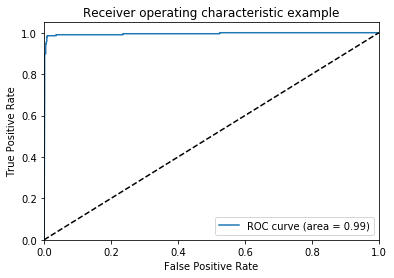

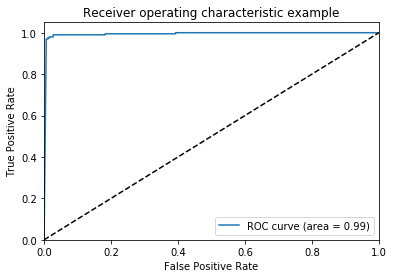

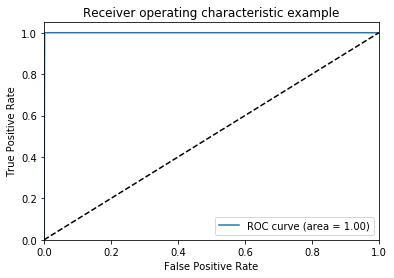

In [25]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
y_pred

array([[1.06448295e-10, 1.00000000e+00, 7.73484166e-10, 7.67624464e-10],
       [6.06039408e-19, 1.83316976e-19, 1.41195827e-24, 1.00000000e+00],
       [9.99999285e-01, 2.22708856e-08, 6.23291818e-09, 1.03436196e-19],
       ...,
       [1.26098597e-18, 1.86559291e-19, 9.41845194e-25, 1.00000000e+00],
       [6.46570027e-17, 9.05877914e-17, 4.98629966e-21, 1.00000000e+00],
       [8.82523840e-16, 1.00000000e+00, 1.16102462e-16, 1.25404407e-19]],
      dtype=float32)

In [27]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
y_pred

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [28]:
y_te

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [29]:
roc_auc_score(y_te, y_pred)

0.9829361417940715

In [30]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[613   3]
  [ 16 190]]

 [[608  16]
  [  4 194]]

 [[622   3]
  [  0 197]]

 [[599   2]
  [  0 221]]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       206
           1       0.92      0.98      0.95       198
           2       0.98      1.00      0.99       197
           3       0.99      1.00      1.00       221

   micro avg       0.97      0.98      0.97       822
   macro avg       0.97      0.98      0.97       822
weighted avg       0.97      0.98      0.97       822
 samples avg       0.97      0.98      0.97       822



In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)


In [32]:
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))

Hamming score: 0.9732360097323601


In [33]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.9708029197080292
Hamming loss: 0.01338199513381995


In [34]:
X_t[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 2274],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   14,   48,   13,
           8,   96,  309,  372,   30,  107]])

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)) 

array([[190,  12,   2,   2],
       [  3, 194,   1,   0],
       [  0,   0, 197,   0],
       [  0,   0,   0, 221]], dtype=int64)

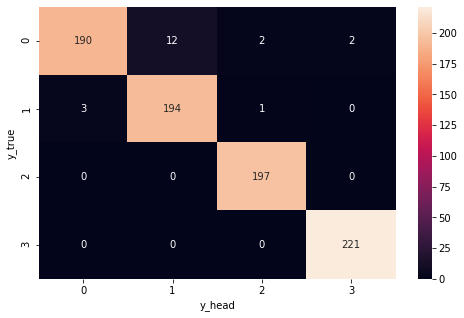

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()